Wszystkie algorytmy poniżej będą skupiały się na klasteryzacji

### KMeans

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, fowlkes_mallows_score, homogeneity_score, mutual_info_score, normalized_mutual_info_score, rand_score, v_measure_score
import sys
from io import StringIO
import numpy as np

Przez to, że dane tworzone są za pomocą make_blobs, w którym podaje się środki klastrów, można przekazać znaną już z góry potrzebną liczbę klastrów. make_blobs zwraca także labele, do których należą punkty - dzięki temu można użyć między innymi hyperparameter tuning przy pomocy GridSearchCV, czy też przeprowadzić ewaluację na części testowej za pomocą metryk z sklearn.metrics dla klasteryzacji

In [2]:
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, y = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7, random_state=0)
X

array([[ 0.04840052, -0.60431296],
       [-2.90377556, -1.76762122],
       [ 0.76034237, -1.21721296],
       ...,
       [-0.63132708, -1.3974623 ],
       [-1.47312419, -1.28925192],
       [ 0.98895455,  0.65578892]])

In [3]:
y

array([1, 1, 2, ..., 2, 1, 0])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### KMeans

In [5]:
k_means = KMeans()
k_means.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 10,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [6]:
hyperparams = {
    'algorithm' : ('auto', 'elkan'), # auto to to samo co 'full' i 'lloyd'
    'n_clusters' : [n_clusters]
}
grid = GridSearchCV(estimator=k_means, param_grid=hyperparams, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'algorithm': 'auto', 'n_clusters': 3}

In [7]:
k_means = KMeans(**grid.best_params_, verbose=True, random_state=2)
k_means.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 10,
 'random_state': 2,
 'tol': 0.0001,
 'verbose': True}

Inercja pełni w tym problemie rolę funkcji straty - dla KMeans hiperparametr n_init oznacza: "Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia."

In [8]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

k_means.fit(X_train)

sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
run_number = 0
iteration_results_in_run = []
for line in loss_history.split('\n'):
    if 'Initialization complete' in line:
        if run_number > 0:
            loss_list.append((run_number, iteration_results_in_run))
        run_number += 1
        iteration_results_in_run = []
        continue
    line_split = line.split("inertia ")
    if(len(line_split) == 1):
        continue
    else:
        iteration_results_in_run.append(float(line_split[1]))

print(loss_list)

[(1, [2165.5318583457465, 1745.46628132057, 1705.9577843267084, 1701.1963258413825, 1699.0950744693791, 1698.7473768292152]), (2, [2827.861519466686, 1765.8679389908252, 1711.2556935624725, 1701.772133236283, 1699.2376484356396, 1698.7502094431732]), (3, [2521.5661890855795, 1770.9856764705125, 1712.1362647956798, 1701.7153228601019, 1699.696480990981, 1699.0255343510173, 1698.779754698294]), (4, [3151.046373003507, 1910.401950325246, 1742.1313813225368, 1709.1669910779528, 1700.8948310515627, 1699.6291333162949, 1698.9822346911933, 1698.7797546982945]), (5, [2678.6189769381076, 1713.3525025774914, 1699.6423486677384, 1698.9185582728473, 1698.7753025959978]), (6, [2706.29065723967, 1795.8145494583416, 1705.9539353570121, 1699.4464089959733, 1698.8728029877384]), (7, [2669.6769684059486, 2237.9175196641177, 1979.2568199054845, 1792.6969649902835, 1729.7416335733517, 1706.0469482977062, 1700.427849719725, 1698.872030908874, 1698.7493900718696]), (8, [3056.0833254941294, 2754.451870904754

In [9]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = pairwise_distances_argmin(X_train, k_means_cluster_centers)

In [10]:
k_means_cluster_centers

array([[ 1.08173464, -1.056958  ],
       [-1.07208796, -0.97097654],
       [ 0.97532887,  1.01028562]])

In [11]:
k_means_labels

array([2, 1, 1, ..., 1, 2, 1], dtype=int64)

Inercja - "Sum of distances of samples to their closest cluster center." - czyli strata mierzona odległością

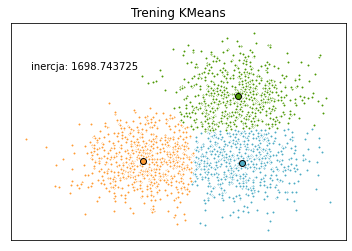

In [12]:
# KMeans
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

for k, color in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X_train[my_members, 0], X_train[my_members, 1], "w", markerfacecolor=color, marker=".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Trening KMeans")
plt.xticks(())
plt.yticks(())
plt.text(-3.5, 1.8, "inercja: %f" % (k_means.inertia_))

plt.show()

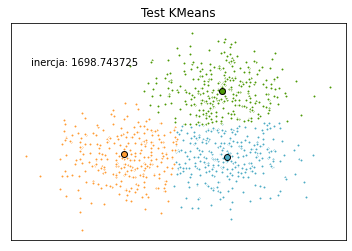

In [13]:
y_pred = k_means.predict(X_test)
k_means_labels = pairwise_distances_argmin(X_test, k_means_cluster_centers)

for k, color in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X_test[my_members, 0], X_test[my_members, 1], "w", markerfacecolor=color, marker=".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Test KMeans")
plt.xticks(())
plt.yticks(())
plt.text(-3, 1.8, "inercja: %f" % (k_means.inertia_))

plt.show()

In [14]:
lowest_inertia_idx = 0
lowest_inertia = min(loss_list[0][1])
for loss_list_item in loss_list:
    if (min(loss_list_item[1]) < lowest_inertia):
        lowest_inertia = min(loss_list_item[1])
        lowest_inertia_idx = loss_list_item[0]
print(lowest_inertia_idx)
print(lowest_inertia)

0
1698.7473768292152


Pierwszy przebieg dla KMeans ma najmniejszą inercję, a według opisu hiperparametru n_init to właśnie ten przebieg zostanie finalnie wybrany

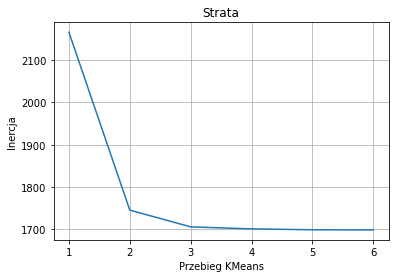

In [15]:
plt.plot(np.arange(1, len(loss_list[lowest_inertia_idx][1]) + 1, 1), loss_list[lowest_inertia_idx][1])
plt.xlabel('Przebieg KMeans')
plt.ylabel('Inercja')
plt.title('Strata')
plt.grid()
plt.show()

In [16]:
print('adjusted_mutual_info_score: ' , adjusted_mutual_info_score(y_test, y_pred))
print('adjusted_rand_score: ' , adjusted_rand_score(y_test, y_pred))
print('completeness_score: ' , completeness_score(y_test, y_pred))
print('fowlkes_mallows_score: ' , fowlkes_mallows_score(y_test, y_pred))
print('homogeneity_score: ' , homogeneity_score(y_test, y_pred))
print('mutual_info_score: ' , mutual_info_score(y_test, y_pred))
print('normalized_mutual_info_score: ' , normalized_mutual_info_score(y_test, y_pred))
print('rand_score: ' , rand_score(y_test, y_pred))
print('v_measure_score: ' , v_measure_score(y_test, y_pred))

adjusted_mutual_info_score:  0.6366483550509823
adjusted_rand_score:  0.6957528276705703
completeness_score:  0.637205522388481
fowlkes_mallows_score:  0.7971551218924826
homogeneity_score:  0.6375670447827
mutual_info_score:  0.699570741676919
normalized_mutual_info_score:  0.6373862323221554
rand_score:  0.8647880360894822
v_measure_score:  0.6373862323221553


### MiniBatchKMeans

In [17]:
minibatch_k_means = MiniBatchKMeans()
minibatch_k_means.get_params()

{'batch_size': 1024,
 'compute_labels': True,
 'init': 'k-means++',
 'init_size': None,
 'max_iter': 100,
 'max_no_improvement': 10,
 'n_clusters': 8,
 'n_init': 3,
 'random_state': None,
 'reassignment_ratio': 0.01,
 'tol': 0.0,
 'verbose': 0}

In [18]:
hyperparams = {
    'batch_size' : [128, 256, 512, 1024],
    'max_no_improvement' : [3]
}
grid = GridSearchCV(estimator=minibatch_k_means, param_grid=hyperparams, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment var

{'batch_size': 1024, 'max_no_improvement': 3}

In [19]:
minibatch_k_means = MiniBatchKMeans(**grid.best_params_, random_state=3, verbose=True)
minibatch_k_means.get_params()

{'batch_size': 1024,
 'compute_labels': True,
 'init': 'k-means++',
 'init_size': None,
 'max_iter': 100,
 'max_no_improvement': 3,
 'n_clusters': 8,
 'n_init': 3,
 'random_state': 3,
 'reassignment_ratio': 0.01,
 'tol': 0.0,
 'verbose': True}

In [20]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

minibatch_k_means.fit(X_train)

sys.stdout = old_stdout
loss_history = mystdout.getvalue()
mean_batch_inertia_list = []
minibatch_step = 0
iteration_results_in_run = []
for line in loss_history.split('\n'):
    if 'Minibatch step' not in line:
        continue
    else:
        if ',' in line:
            line_split = line.split(',')
            mean_batch_inertia = line_split[0].split('mean batch inertia: ')[1]
        else:
            mean_batch_inertia = line.split('mean batch inertia: ')[1]
        mean_batch_inertia_list.append(float(mean_batch_inertia))

print(mean_batch_inertia_list)

[0.4067987056788396, 0.3816613195698396, 0.3722546411567925, 0.3900803814288966, 0.3890115230788304, 0.37052348128100276, 0.3719731166268916, 0.36462763232830153, 0.36891678610403983, 0.37212229225415805, 0.39372088988055354]


C:\Users\mcham\anaconda3\envs\tf-gpu-280\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [21]:
minibatch_k_means_cluster_centers = minibatch_k_means.cluster_centers_
minibatch_k_means_labels = pairwise_distances_argmin(X_train, minibatch_k_means_cluster_centers)

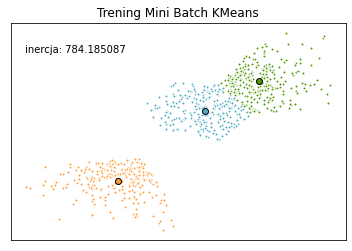

In [22]:
# Mini Batch KMeans
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

for k, color in zip(range(n_clusters), colors):
    my_members = minibatch_k_means_labels == k
    cluster_center = minibatch_k_means_cluster_centers[k]
    plt.plot(X_train[my_members, 0], X_train[my_members, 1], "w", markerfacecolor=color, marker=".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Trening Mini Batch KMeans")
plt.xticks(())
plt.yticks(())
plt.text(-3, 1.8, "inercja: %f" % (minibatch_k_means.inertia_))

plt.show()

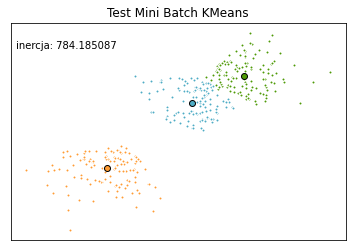

In [23]:
y_pred = minibatch_k_means.predict(X_test)
minibatch_k_means_labels = pairwise_distances_argmin(X_test, minibatch_k_means_cluster_centers)

for k, color in zip(range(n_clusters), colors):
    my_members = minibatch_k_means_labels == k
    cluster_center = minibatch_k_means_cluster_centers[k]
    plt.plot(X_test[my_members, 0], X_test[my_members, 1], "w", markerfacecolor=color, marker=".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Test Mini Batch KMeans")
plt.xticks(())
plt.yticks(())
plt.text(-3, 1.8, "inercja: %f" % (minibatch_k_means.inertia_))

plt.show()

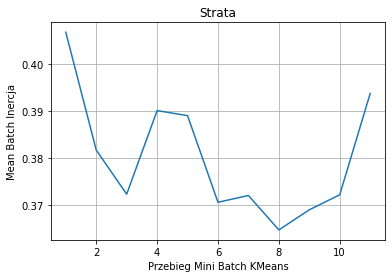

In [24]:
plt.plot(np.arange(1, len(mean_batch_inertia_list) + 1, 1), mean_batch_inertia_list)
plt.xlabel('Przebieg Mini Batch KMeans')
plt.ylabel('Mean Batch Inercja')
plt.title('Strata')
plt.grid()
plt.show()

In [25]:
print('adjusted_mutual_info_score: ' , adjusted_mutual_info_score(y_test, y_pred))
print('adjusted_rand_score: ' , adjusted_rand_score(y_test, y_pred))
print('completeness_score: ' , completeness_score(y_test, y_pred))
print('fowlkes_mallows_score: ' , fowlkes_mallows_score(y_test, y_pred))
print('homogeneity_score: ' , homogeneity_score(y_test, y_pred))
print('mutual_info_score: ' , mutual_info_score(y_test, y_pred))
print('normalized_mutual_info_score: ' , normalized_mutual_info_score(y_test, y_pred))
print('rand_score: ' , rand_score(y_test, y_pred))
print('v_measure_score: ' , v_measure_score(y_test, y_pred))

adjusted_mutual_info_score:  0.4670199857686961
adjusted_rand_score:  0.29990378647035343
completeness_score:  0.35922315598765364
fowlkes_mallows_score:  0.47963551145883854
homogeneity_score:  0.6781211386388375
mutual_info_score:  0.7440687403566388
normalized_mutual_info_score:  0.46965470736308335
rand_score:  0.7371474477814856
v_measure_score:  0.46965470736308335


### AffinityPropagation

In [26]:
mean_shift = MeanShift()
mean_shift.get_params()

{'bandwidth': None,
 'bin_seeding': False,
 'cluster_all': True,
 'max_iter': 300,
 'min_bin_freq': 1,
 'n_jobs': None,
 'seeds': None}

Hiperparametry MeanShift takie jak bandwidth czy seeds są domyślnie obliczane za pomocą specjalnych metod. Poza tym, reszta odpowiada za szybkość algorytmu - dlatego zrezygnowano z szukania najlepszej kombinacji w tym przypadku

In [27]:
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=150)
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)

mean_shift.fit(X_train)

MeanShift(bandwidth=1.0880084177499902, bin_seeding=True)

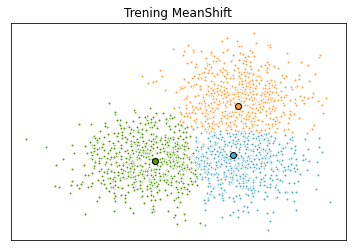

In [28]:
mean_shift_cluster_centers = mean_shift.cluster_centers_
mean_shift_labels = pairwise_distances_argmin(X_train, mean_shift_cluster_centers)

colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

for k, color in zip(range(n_clusters), colors):
    my_members = mean_shift_labels == k
    cluster_center = mean_shift_cluster_centers[k]
    plt.plot(X_train[my_members, 0], X_train[my_members, 1], "w", markerfacecolor=color, marker=".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Trening MeanShift")
plt.xticks(())
plt.yticks(())

plt.show()

Oszacowana liczba klastrów:  3


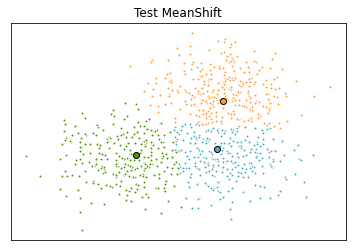

In [29]:
y_pred = mean_shift.predict(X_test)
mean_shift_labels = pairwise_distances_argmin(X_test, mean_shift_cluster_centers)
print("Oszacowana liczba klastrów: ", len(np.unique(mean_shift_labels)))

for k, color in zip(range(n_clusters), colors):
    my_members = mean_shift_labels == k
    cluster_center = mean_shift_cluster_centers[k]
    plt.plot(X_test[my_members, 0], X_test[my_members, 1], "w", markerfacecolor=color, marker=".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Test MeanShift")
plt.xticks(())
plt.yticks(())

plt.show()

Dla MeanShift nie ma opcji zobaczenia przebiegu funkcji straty

In [30]:
print('adjusted_mutual_info_score: ' , adjusted_mutual_info_score(y_test, y_pred))
print('adjusted_rand_score: ' , adjusted_rand_score(y_test, y_pred))
print('completeness_score: ' , completeness_score(y_test, y_pred))
print('fowlkes_mallows_score: ' , fowlkes_mallows_score(y_test, y_pred))
print('homogeneity_score: ' , homogeneity_score(y_test, y_pred))
print('mutual_info_score: ' , mutual_info_score(y_test, y_pred))
print('normalized_mutual_info_score: ' , normalized_mutual_info_score(y_test, y_pred))
print('rand_score: ' , rand_score(y_test, y_pred))
print('v_measure_score: ' , v_measure_score(y_test, y_pred))

adjusted_mutual_info_score:  0.6460362000301658
adjusted_rand_score:  0.6996846864381802
completeness_score:  0.6466778021004851
fowlkes_mallows_score:  0.7998131911484959
homogeneity_score:  0.6468324814826899
mutual_info_score:  0.70973724648173
normalized_mutual_info_score:  0.6467551325432221
rand_score:  0.8665109380793474
v_measure_score:  0.6467551325432221
